In [122]:
import pandas as pd
import numpy as np
import random as rnd
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [123]:
def titanic(train, test):
    train_df = pd.read_csv(train)
    test_df = pd.read_csv(test)
    combine = [train_df, test_df]

    train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
    test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
    combine = [train_df, test_df]

    for dataset in combine:
        dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

    pd.crosstab(train_df['Title'], train_df['Sex'])

    for dataset in combine:
        dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

        dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    for dataset in combine:
        dataset['Title'] = dataset['Title'].map(title_mapping)
        dataset['Title'] = dataset['Title'].fillna(0)

    train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
    test_df = test_df.drop(['Name'], axis=1)
    combine = [train_df, test_df]

    for dataset in combine:
        dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

    guess_ages = np.zeros((2,3))
    guess_ages

    for dataset in combine:
        for i in range(0, 2):
            for j in range(0, 3):
                guess_df = dataset[(dataset['Sex'] == i) & \
                                      (dataset['Pclass'] == j+1)]['Age'].dropna()

                # age_mean = guess_df.mean()
                # age_std = guess_df.std()
                # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

                age_guess = guess_df.median()

                # Convert random age float to nearest .5 age
                guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

        for i in range(0, 2):
            for j in range(0, 3):
                dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                        'Age'] = guess_ages[i,j]

        dataset['Age'] = dataset['Age'].astype(int)

    for dataset in combine:
        dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1



    for dataset in combine:
        dataset['IsAlone'] = 0
        dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

    combine = [train_df, test_df]

    freq_port = train_df.Embarked.dropna().mode()[0]

    for dataset in combine:
        dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

    test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

    test_df.head(10)
    return (train_df, test_df)

In [124]:
train_t, test_t  = titanic("./titanic/train.csv","./titanic/test.csv")

In [125]:
train_t = pd.get_dummies(train_t)

In [126]:
test_t = pd.get_dummies(test_t)

In [127]:
Y_train = train_t['Survived']

In [128]:
X_train = test_t['PassengerId']

In [129]:
del test_t['PassengerId']

In [139]:
model = DecisionTreeClassifier(max_depth = 3)

In [140]:
model.fit(train_t[train_t.columns.tolist()[1:]],Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [141]:
sur = model.predict(test_t)

In [142]:
#df = pd.DataFrame(np.array([X_train,sur]).T,columns=['PassengerId','Survived'])

In [134]:
#df.to_csv('predicted.csv',index=False)

In [143]:
def decision_tree(clf,feature_names,class_names):
    from IPython.display import Image 
    from StringIO import StringIO
    import pydotplus
    dot_data = StringIO()  
    tree.export_graphviz(clf, out_file=dot_data,  
                             feature_names=feature_names,  
                             class_names=class_names,  
                             filled=True, rounded=True,  
                             special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())
    

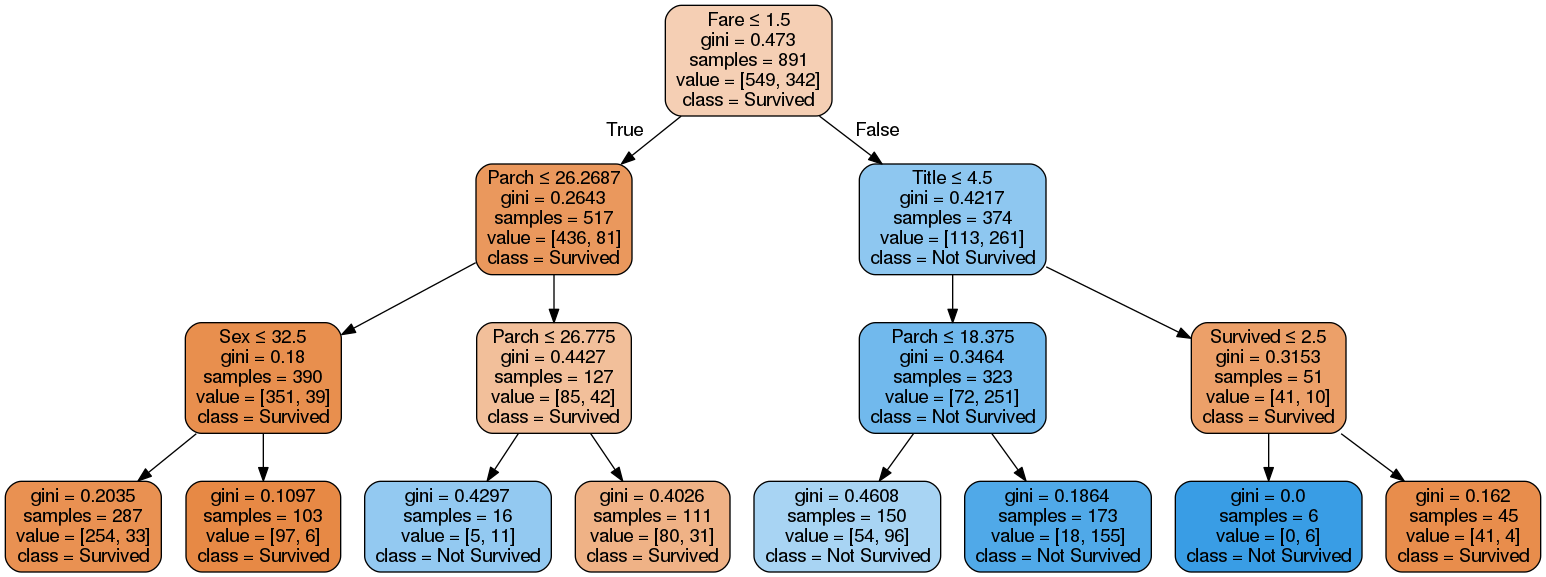

In [145]:
decision_tree(model,train_t.columns,['Survived','Not Survived'])

In [183]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV

X = train_t[train_t.columns.tolist()[1:]]
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, Y_train,
                            test_size=num_test, random_state=23)

clf = RandomForestClassifier(random_state=30,oob_score=True)
parameters = {'n_estimators':  [120,130,145], 
              'max_features': ['log2','sqrt'],
              'criterion': ['entropy'],
              'max_depth': [5], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 2, 3],
             }

acc_scorer = make_scorer(accuracy_score)
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

clf_best = grid_obj.best_estimator_

clf_best.fit(X_train, y_train)

print accuracy_score(clf_best.predict(X_test),y_test)

0.810055865922


In [182]:
clf_best
    

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=120, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)